In [2]:
# Import various libraries 

import numpy as np
import astropy
import photutils
import ccdproc
from ccdproc import CCDData, combiner
from astropy import units as u
import astropy.io.fits as fits
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils import centroid_com, centroid_1dg, centroid_2dg
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import Background2D
from photutils import MedianBackground
from photutils import DAOStarFinder
from photutils import detect_sources, deblend_sources, source_properties
from scipy.ndimage import shift
import gc    
from matplotlib.pyplot import *
from numpy import *

from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
# Here's the star class, which includes a name, coordinates, exposure time, airmass, UBVRI fluxes, UBVRI magnitudes. 

class Star:
    def __init__(self):
            self.name = "Default name"                                # Object name
            self.filename = "NULL                                  "  # Image file name
            self.ra = -99.0                                           # J2000 coords ra+dec (initially given dummy values)
            self.dec = -99.0
            self.x = -99.0                                            # CCD pixel coords x-y (intially given dummy values)
            self.y = -99.0
            self.flux = [-99.0,-99.0,-99.0,-99.0,-99.0]               # UBVRI Fluxes (intially given dummy values)
            self.mag = [-99.0,-99.0,-99.0,-99.0,-99.0]                # UBRRI Magnitudes (intially given dummy values)
            self.gaiamag = [-99.0, -99.0, -99.0]                      # G_BP, G and G_RP Magnitudes (intially given dummy values)
            self.exptime = 1.0
            self.airmass = 1.0

In [4]:
# This reads in the photometry from the Graham (1982) standard star photometry and converts to decimal degrees

def readgraham(fname):
    
  # Set the list of standards to a blank list.
    gstandards=[]

    # Open the text file defined by fname, then import the ASCII lines from the file into grahamtext
    with open(fname) as f:
        grahamtext = f.readlines()
    
    # Step through each line of grahamtext. The current line is thisline and it has index imx
    for imx, thisline in enumerate(grahamtext): 

        # Read in coordinates - each variable has specific columns, defined in the README file
        rah=float(thisline[15:17])   # Read in RA hours from the ASCII, and covert to float
        ram=float(thisline[18:20])   # Read in RA minutes from the ASCII, and covert to float
        ras=float(thisline[21:25])   # Read in RA seconds from the ASCII, and covert to float
        decd=float(thisline[27:29])  # Read in Dec degreess from the ASCII, and convert to float
        decm=float(thisline[30:32])  # Read in Dec arcminutes from the ASCII, and convert to float
        decs=float(thisline[33:35])  # Read in Dec arcseconds from the ASCII, and convert to float
        
        # Convert the coordinates to decimal degrees. 
        ra=15.0*(rah+ram/60.0+ras/3600.0)   # Convert RA to decimal degrees
        dec=decd+decm/60.0+decs/3600.0      # Convert Declination to decimal degrees
        if thisline[26]=='-':               # If the declination is negative, convert accordingly
            dec=0-dec
    
        # Read in the photometry 
        tmag=[-99.0,-99.0,-99.0,-99.0,-99.0]        # Temporary UBVRI magnitude list - initially unphysical values 
        tmag[2]=float(thisline[36:41])              # Read V magnitude from thisline and convert to float
        tmag[1]=float(thisline[50:56])+tmag[2]      # Read in B-V colour from thisline, convert to float, produce B magnitude.
        if (thisline[47]!=' '):
            tmag[0]=float(thisline[50:56])+tmag[1]  # Read in U-B colour from thisline (if available), convert to float, produce U magnitude
        tmag[3]=tmag[2]-float(thisline[57:62])      # Read in V-R colour from thisline, convert to float, prodcue R magnitude
        if (thisline[68]!=' '):
            tmag[4]=tmag[3]-float(thisline[64:69])  # Read in R-I colour from thisline, convert to float, produce I magnitude 
        
        # Create temporary tstandard, which has class star, and populate it with data from Graham (1982)
        tstandard=Star()                            # Create tstandard with class star
        tstandard.name=thisline[0:12]               # Get the name from thisline
        tstandard.ra=ra                             # Get the RA
        tstandard.dec=dec                           # Get the Declination
        tstandard.mag=tmag                          # Get the UBVRI magnitudes
        
        # Extend the list gstandards with tstandard
        gstandards.extend([tstandard])

    # The end of the indentation is where there's the end of the for-loop
    
    # The end of the function, which returns the list of Graham Standards names, coordinates and UBVRI magnitudes 
    return gstandards

In [5]:
gstandards=readgraham('Graham1982.txt')
print(len(gstandards))
print(gstandards[0].ra, gstandards[0].dec, gstandards[0].mag)

102
21.174583333333334 -44.52833333333333 [8.562, 7.4159999999999995, 6.27, 5.699999999999999, 5.1899999999999995]


In [6]:
def getgaia(gstandards):
    for obj in gstandards:
        coord = SkyCoord(ra=obj.ra, dec=obj.dec, unit=(u.degree, u.degree), frame='icrs')
        radius = u.Quantity(0.001, u.deg)
        j = Gaia.cone_search_async(coord, radius)
        r = j.get_results()
        if len(r)>0:
            obj.gaiamag[0]=r[0]['phot_bp_mean_mag']
            obj.gaiamag[1]=r[0]['phot_g_mean_mag']
            obj.gaiamag[2]=r[0]['phot_rp_mean_mag']
    return gstandards

In [7]:
grgaia=[]
f=open("graham_gaia.csv", "r")
grahamtext = f.readlines()
for line in grahamtext:
    currentline = line.split(",")
    if currentline[0]!="Name":
        tstandard=Star()
        tstandard.name=currentline[0]
        tstandard.ra=float(currentline[1])
        tstandard.dec=float(currentline[2])
        tstandard.mag[0]=float(currentline[3])
        tstandard.mag[1]=float(currentline[4])
        tstandard.mag[2]=float(currentline[5])
        tstandard.mag[3]=float(currentline[6])
        tstandard.mag[4]=float(currentline[7])
        tstandard.gaiamag[0]=float(currentline[8])
        tstandard.gaiamag[1]=float(currentline[9])
        tstandard.gaiamag[2]=float(currentline[10])
        grgaia.extend([tstandard])
f.close()


## the RA and dec of the reference star are (137.79726, -64.8156)

In [8]:
gmag=[-99.0, -99.0, -99.0]
coord = SkyCoord(ra=137.79726, dec=-64.8156, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(0.001, u.deg)
j = Gaia.cone_search_async(coord, radius)
r = j.get_results()
if len(r)>0:
    gmag[0]=r[0]['phot_bp_mean_mag']
    gmag[1]=r[0]['phot_g_mean_mag']
    gmag[2]=r[0]['phot_rp_mean_mag']
    print(gmag)

INFO: Query finished. [astroquery.utils.tap.core]
[11.795125, 11.157327, 10.412787]


these values agree with Aladin, which has corresponding values:

<font color=blue> Aladin:
g magnitude - 11.154999 
bp magnitude - 11.70615
rp magnitude - 10.402192 

In [9]:
# px and py are x and y axis
px=[]
py=[]
for obj in grgaia:
    if obj.mag[2]>0.0 and obj.mag[2]<20.0 \
    and obj.gaiamag[0]>0.0 and obj.gaiamag[0]<20.0 \
    and obj.gaiamag[1]>0.0 and obj.gaiamag[1]<20.0 \
    and (obj.mag[2]-obj.gaiamag[1])**2<2.25 :
        px.append(obj.gaiamag[0]-obj.gaiamag[1])      # G_BP minus G
        py.append(obj.mag[2]-obj.gaiamag[1])          # V minus G

In [10]:
# we can find the magnitude for the V, R and I bands using the relations given on moodle:
# V - G = 0.00858 + 0.22184 (GBP - G) + 0.48446 (GBP - G)2
# R - GRP = 0.01283 + 0.33460 (G - GRP) + 0.40048 (G - GRP)2
# I - GRP = 0.00216 - 0.14069 (G - GRP)
# B - GBP = -0.03308 + 1.41139 (GBP - G) 


# V band magnitue
v=0.00858+0.22184*(gmag[0]-gmag[1])+0.48446*(gmag[0]-gmag[1])**2+gmag[1]
print('V band magnitude')
print(v)

# R band magnitude 
R=0.01283+0.33460*(gmag[1]-gmag[2])+0.40048*(gmag[1]-gmag[2])**2+gmag[2]
print('R magnitude')
print(R)

# I band magnitude
I=0.00216 - 0.14069*(gmag[1] - gmag[2])+gmag[2]
print('I magnitude')
print(I)

# B magnitude 
B=-0.03308+1.41139*(gmag[0]-gmag[1])+gmag[0]
print('B magnitude')
print(B)

Bref=B
Vref=v
Rref=R
Iref=I

V band magnitude
11.504467751874088
R magnitude
10.896741841092728
I magnitude
10.310198208827972
B magnitude
12.662227163429261


##### <font color=purple> Starting with cataloguing V band magnitudes

We start by creating a catalogue of the stars in our image

In [11]:
# creating a catalogue for the stars in NGC 2808
# based on lab 3 which used segmentation 
scim=CCDData.read("NGC_2808_V_median.fits", unit="adu") # reading the data from the file
med=np.median(scim.data) # defining the median of the data 
scim.data=scim.data-med #subtracting median
mean, median, std = astropy.stats.sigma_clipped_stats(scim.data, sigma=3.0, maxiters=5)    
print('Image stats (mean, median and standard deviation):', mean,median,std) # calculating mean, median, standard deviation (printing image stats)

segimage=detect_sources(scim.data, 2.00*std, 9, connectivity=4, mask=None) #defining segmentation image


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]
Image stats (mean, median and standard deviation): -0.44846767 -2.0487838 114.902664


Text(0, 0.5, 'y coordinate')

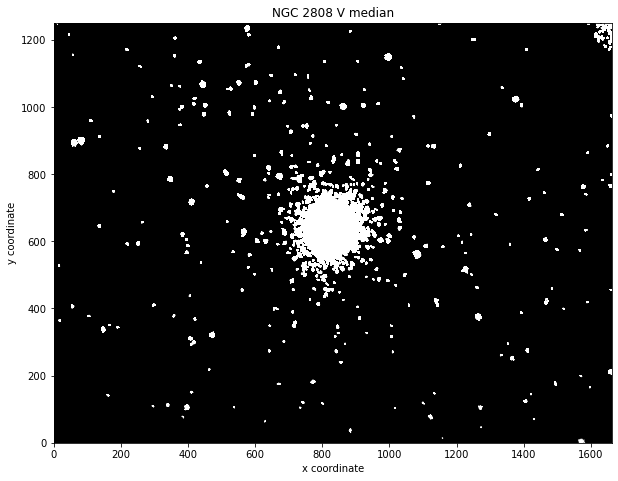

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(segimage.data, cmap='gray', vmin=0, vmax=1, origin='lower')
plt.title('NGC 2808 V median')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')

The source table gives the x and y pixel coordinates of each star as well as the aperture sum in ADU

In [13]:
# Creating a source table
source_table=source_properties(scim.data, segimage, error=None, mask=None, background=None, filter_kernel=None, wcs=None, labels=None)
print('Source table length:\n', len(source_table))
print('First entry centroid y and x values :') # The dreaded y-x
print(source_table[0].centroid[0].value, source_table[0].centroid[1].value)

Source table length:
 499
First entry centroid y and x values :
4.905264395724232 1570.1284325241668


In [14]:
# xy format for centroid positions
positions=[]
for obj in source_table:
    positions.append((obj.centroid[1].value, obj.centroid[0].value))
print(positions[0:10]) # Print example values from the positions list.
apertures = CircularAperture (positions, r=10) #code taken from Lab 3
phot_table_v = aperture_photometry(scim, apertures)
print(phot_table_v)

[(1570.1284325241668, 4.905264395724232), (1157.246646154549, 14.32187906690173), (882.3934690141442, 37.028307580722846), (1272.5917543931037, 46.43042978397951), (628.4191326180189, 64.24233285503477), (1430.0818798461169, 70.56217347028978), (1121.5945988035332, 77.49679956991102), (383.9229346192441, 77.23882157911514), (391.81986949428307, 99.72020358808204), (396.2950152473696, 106.27068736117312)]
 id      xcenter            ycenter          aperture_sum   
           pix                pix                adu        
--- ------------------ ------------------ ------------------
  1 1570.1284325241668  4.905264395724232  259741.1646383857
  2  1157.246646154549  14.32187906690173  9022.252264400273
  3  882.3934690141442 37.028307580722846 24639.261444878222
  4 1272.5917543931037  46.43042978397951  9292.172108490739
  5  628.4191326180189  64.24233285503477   1695.95701702502
  6 1430.0818798461169  70.56217347028978 12324.733012375618
  7 1121.5945988035332  77.49679956991102  

In [15]:
#### Aperture sum and positions of reference star at (1264,375) in V median image
for idx, obj in enumerate(phot_table_v):
        if obj['xcenter'].value>1200 and obj['xcenter'].value<1300 \
        and obj['ycenter'].value>300 and obj['ycenter'].value<400 :
            refidx=idx
            print(idx, obj['xcenter'].value, obj['ycenter'].value, obj['aperture_sum'])
            

59 1263.05608553992 375.4302838747978 277373.31402309495 adu


In [16]:
#### Aperture sum and positions fainter star at (1264,375) in V median image
for idx, obj in enumerate(phot_table_v):
        if obj['xcenter'].value>1200 and obj['xcenter'].value<1230 \
        and obj['ycenter'].value>300 and obj['ycenter'].value<400 :
            refidx=idx
            print(idx, obj['xcenter'].value, obj['ycenter'].value, obj['aperture_sum'])

In [17]:
# finding the magnitude of the fainter star using the flux and known magnitude of reference star
f1= 118633.9433912482
f2= phot_table_v[refidx]['aperture_sum'].value # 260577.88624417983
m2= Vref   # roughly 7.02390159404841
m1= m2-2.5*np.log10(f1/f2)
print(m2,f2)
print(m1, f1)


11.504467751874088 277373.31402309495
12.426607024024381 118633.9433912482


In [18]:
V_mag=[]
print(m2,f2)
for obj in phot_table_v:
    V_mag.append(Vref-2.5*np.log10(obj['aperture_sum'].value/f2))
print(V_mag)

11.504467751874088 277373.31402309495
[11.575777481718085, 15.223842025709857, 14.133060225917792, 15.191836327609044, 17.03859233764865, 14.885185640396084, 13.076134740137954, 15.367090132390778, 12.469944708096115, 12.17950864998501, 13.259761440391573, 16.219916746290572, 14.93694877675702, 14.73552331025991, nan, 13.869048029975446, 14.422315096345791, 15.184052615981491, 14.38753002921245, 14.095196196103547, nan, 15.031873956662132, 15.520794362844814, 15.072059771022204, 15.96097000370493, 14.071584833961719, 15.13121190281211, 13.676089968344385, 17.145805500975875, 13.089583008345423, 17.805522666894138, 14.045088637851855, 13.993350521567725, 14.603753099300045, 14.490086711405747, 15.395893431631231, 13.718243303935303, 15.372780724323672, 14.366011927342662, 13.672963425896567, 14.872983642627126, 17.055076669068413, 13.649214105689243, 14.45512900195995, 13.681438304306763, 12.09875807071633, 14.507794983095714, 15.322083480783322, 17.269562363249726, 14.981992821543933, 

# <font color = purple> I band cataloguing


Repeating steps for the other filters (minus source table)

In [19]:
scim=CCDData.read("NGC_2808_I_median.fits", unit="adu") # reading the data from the file
med=np.median(scim.data) # defining the median of the data 
scim.data=scim.data-med #subtracting median
mean, median, std = astropy.stats.sigma_clipped_stats(scim.data, sigma=3.0, maxiters=5)    
print('Image stats (mean, median and standard deviation):', mean,median,std) # calculating mean, median, standard deviation (printing image stats)

INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]
Image stats (mean, median and standard deviation): -0.037260514 -3.0589023 164.70932


In [20]:
# xy format for centroid positions
positions=[]
for obj in source_table:
    positions.append((obj.centroid[1].value, obj.centroid[0].value))
print(positions[0:10]) # Print example values from the positions list.
apertures = CircularAperture (positions, r=10) #code taken from Lab 3
phot_table_i = aperture_photometry(scim, apertures)
print(phot_table_i)

# Aperture sum and positions of reference star at (1265,373) in V median image
for idx, obj in enumerate(phot_table_i):
        if obj['xcenter'].value>1200 and obj['xcenter'].value<1300 \
        and obj['ycenter'].value>300 and obj['ycenter'].value<400:
                print(idx, obj['xcenter'].value, obj['ycenter'].value, obj['aperture_sum'])


[(1570.1284325241668, 4.905264395724232), (1157.246646154549, 14.32187906690173), (882.3934690141442, 37.028307580722846), (1272.5917543931037, 46.43042978397951), (628.4191326180189, 64.24233285503477), (1430.0818798461169, 70.56217347028978), (1121.5945988035332, 77.49679956991102), (383.9229346192441, 77.23882157911514), (391.81986949428307, 99.72020358808204), (396.2950152473696, 106.27068736117312)]
 id      xcenter            ycenter          aperture_sum   
           pix                pix                adu        
--- ------------------ ------------------ ------------------
  1 1570.1284325241668  4.905264395724232  212682.4140365344
  2  1157.246646154549  14.32187906690173 1247.8469382711837
  3  882.3934690141442 37.028307580722846  20216.16805381552
  4 1272.5917543931037  46.43042978397951  4070.705006016732
  5  628.4191326180189  64.24233285503477  4309.214601035967
  6 1430.0818798461169  70.56217347028978  15980.71146968435
  7 1121.5945988035332  77.49679956991102  

In [21]:
#### Aperture sum and positions fainter star at (1264,375) in V median image
for idx, obj in enumerate(phot_table_v):
        if obj['xcenter'].value>1220 and obj['xcenter'].value<1230 \
        and obj['ycenter'].value>500 and obj['ycenter'].value<520 :
            refidx=idx
            print(idx, obj['xcenter'].value, obj['ycenter'].value, obj['aperture_sum'])

112 1225.2625131754075 516.2551530299908 130014.57222438144 adu


In [22]:
# finding the magnitude of the fainter star using the flux and known magnitude of reference star
f1= 127139.71057166517
f2= phot_table_i[refidx]['aperture_sum'].value  # 348375.16274801537
m2= Iref # 5.987310474624634
m1= m2-2.5*np.log10(f1/f2)
print(m2, f2)
print(m1, f1)

10.310198208827972 212155.25998842556
10.866129672089041 127139.71057166517


In [23]:
I_mag=[]
for i in range(len(phot_table_i)):
    print(phot_table_i['aperture_sum'][i].value)
    I_mag.append(m2-2.5*np.log10(phot_table_i[i]['aperture_sum'].value/f2))
print(I_mag)
print(len(I_mag))
print(I_mag[0])

212682.4140365344
1247.8469382711837
20216.16805381552
4070.705006016732
4309.214601035967
15980.71146968435
70176.8129309905
14683.5217922284
151637.89062945382
196592.21075901028
40713.75701165882
6009.93607938378
9661.945814777278
18995.402721987608
-10397.307166896564
98509.59811782805
22695.69454139105
4299.369332204415
17526.77465452383
36707.191262134584
2713.347411147959
11109.757158417333
23397.26876918837
11516.268322172775
6342.775192186029
13041.852026944485
12145.58100690235
80205.58292883105
3763.7628512574656
216850.44108626136
13449.594963528514
36732.202751617515
46011.41208417418
18029.023586351042
32428.631581346974
19211.61786932985
49823.41442684877
12749.691858659899
30492.149485288282
62732.41055549726
16268.48273941307
891.9947944571823
75767.82973113822
19427.284922369094
44665.98316779471
130842.23861417637
16158.818630623868
6572.9189591999175
-98.11559322204766
14293.86330732367
33409.85045635498
9491.414981643935
60297.723007582565
124389.06096955438
10165.

# <font color = purple> R band cataloguing


In [24]:
# creating a catalogue for the stars in NGC 2808
# based on lab 3 which used segmentation ASK MICHAEL AND JAMIE
scim=CCDData.read("NGC_2808_R_median.fits", unit="adu") # reading the data from the file
med=np.median(scim.data) # defining the median of the data 
scim.data=scim.data-med #subtracting median
mean, median, std = astropy.stats.sigma_clipped_stats(scim.data, sigma=3.0, maxiters=5)    
print('Image stats (mean, median and standard deviation):', mean,median,std) # calculating mean, median, standard deviation (printing image stats)

INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]
Image stats (mean, median and standard deviation): -1.3458027 -2.9707332 132.12003


In [25]:
# xy format for centroid positions
positions=[]
for obj in source_table:
    positions.append((obj.centroid[1].value, obj.centroid[0].value))
print(positions[0:10]) # Print example values from the positions list.
apertures = CircularAperture (positions, r=10) #code taken from Lab 3
phot_table_r = aperture_photometry(scim, apertures)
print(phot_table_r)

# Aperture sum and positions of reference star at (1265,373) in V median image
for idx, obj in enumerate(phot_table_r):
        if obj['xcenter'].value>1200 and obj['xcenter'].value<1300 \
        and obj['ycenter'].value>300 and obj['ycenter'].value<400:
                print(idx, obj['xcenter'].value, obj['ycenter'].value, obj['aperture_sum'])

[(1570.1284325241668, 4.905264395724232), (1157.246646154549, 14.32187906690173), (882.3934690141442, 37.028307580722846), (1272.5917543931037, 46.43042978397951), (628.4191326180189, 64.24233285503477), (1430.0818798461169, 70.56217347028978), (1121.5945988035332, 77.49679956991102), (383.9229346192441, 77.23882157911514), (391.81986949428307, 99.72020358808204), (396.2950152473696, 106.27068736117312)]
 id      xcenter            ycenter          aperture_sum   
           pix                pix                adu        
--- ------------------ ------------------ ------------------
  1 1570.1284325241668  4.905264395724232 297272.14518994547
  2  1157.246646154549  14.32187906690173 2592.5698071129245
  3  882.3934690141442 37.028307580722846  29652.64552718414
  4 1272.5917543931037  46.43042978397951 3677.6119910763064
  5  628.4191326180189  64.24233285503477  2652.490122939511
  6 1430.0818798461169  70.56217347028978 11642.583490407946
  7 1121.5945988035332  77.49679956991102  

In [26]:
#### Aperture sum and positions of fainter star at (1264,375) in V median image
for idx, obj in enumerate(phot_table_v):
        if obj['xcenter'].value>1220 and obj['xcenter'].value<1230 \
        and obj['ycenter'].value>500 and obj['ycenter'].value<520 :
            refidx=idx
            print(idx, obj['xcenter'].value, obj['ycenter'].value, obj['aperture_sum'])

112 1225.2625131754075 516.2551530299908 130014.57222438144 adu


In [27]:
# finding the magnitude of the fainter star using the flux and known magnitude of reference star
f1= 130014.57222438144
f2= phot_table_r[refidx]['aperture_sum'].value  # 348375.16274801537
m2= Rref # 5.987310474624634
m1= m2-2.5*np.log10(f1/f2)
print(m2, f2)
print(m1, f1)

10.896741841092728 211059.0565592117
11.422771743839437 130014.57222438144


In [28]:
R_mag=[]
for i in range(len(phot_table_r)):
    print(phot_table_r['aperture_sum'][i].value)
    R_mag.append(m2-2.5*np.log10(phot_table_r[i]['aperture_sum'].value/f2))
print(R_mag)
print(len(R_mag))
print(R_mag[0])

297272.14518994547
2592.5698071129245
29652.64552718414
3677.6119910763064
2652.490122939511
11642.583490407946
76857.35231900291
16366.349399223038
130211.07432452912
224852.49965123262
57689.05619896336
3787.1217362341677
14053.836488472985
19313.25347659336
-9607.680146960898
78046.55275706953
22105.695905287866
6495.215810851161
25039.85918572895
38945.04946794952
3981.4509546317877
8508.180333810884
20529.671058207932
16371.564630608274
3056.7375997881963
22848.89349527518
13965.294573940531
72177.41369620171
2475.3191890766984
113758.74767406638
14390.156337429613
37341.05033965375
47883.21219538553
19254.23954934466
32164.885348874017
14921.148763890737
48857.23917422806
14860.034259420201
20865.736437447293
45428.286480481256
15936.886884188967
-4.294365919483198
73016.27450746993
23366.566360387475
52110.2593963697
187977.24141177261
23244.543013606923
7071.924404369054
2243.874894661118
18384.92892681896
69654.29225766208
15042.631027574955
55431.84375547949
112797.6610890932

In [29]:
print(len(V_mag))
print(len(I_mag))

avg=np.mean(V_mag)
print(avg)

499
499
nan


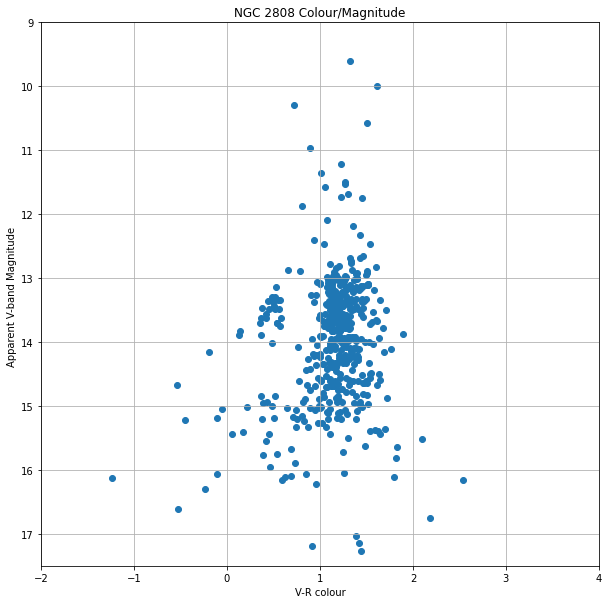

<Figure size 720x720 with 0 Axes>

In [30]:
# need a V-R against V
# Define plot size
plt.rcParams['figure.figsize'] = [10, 10]
plt.axis([-2.0, 4, 17.5, 9])  
# Axis labels and grid
plt.xlabel('V-R colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('NGC 2808 Colour/Magnitude')
plt.grid(True)
px=[]
py=[]
for idx, mag in enumerate(V_mag):
    py.append(mag)
    px.append(V_mag[idx]-R_mag[idx])
plt.scatter(px,py)

plt.show()

#plt.savefig("v-rCMD.png")

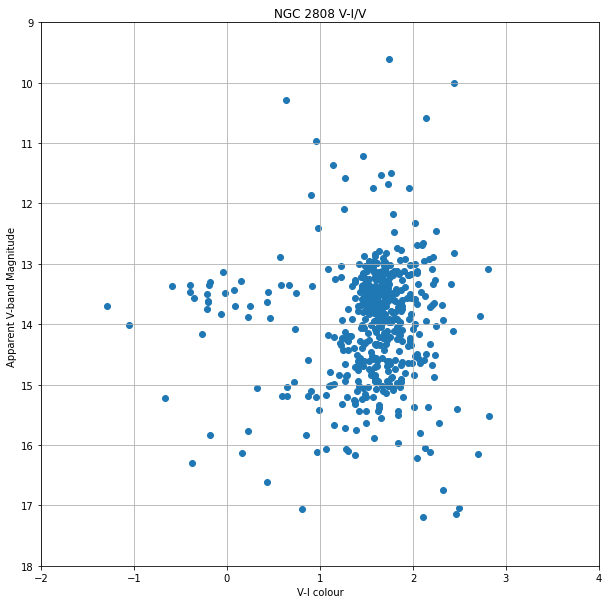

<Figure size 720x720 with 0 Axes>

In [32]:
# need a V-I against V
# Define plot size
plt.rcParams['figure.figsize'] = [10, 10]
plt.axis([-2, 4, 18, 9])  
# Axis labels and grid
plt.xlabel('V-I colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('NGC 2808 V-I/V')
plt.grid(True)
px=[]
py=[]
for idx, mag in enumerate(V_mag):
    py.append(V_mag[idx])
    px.append(V_mag[idx]-I_mag[idx])
plt.scatter(px,py)

plt.show()
#plt.savefig("viCMD.png")


In [388]:
# Solution

class isochroneclass:
    def __init__(self):
            self.filename = "NULL                            "      # Relevant filename
            self.age = -99.0                                        # Age
            self.m = [-99.0]*1000                                   # Star masses
            self.U = [-99.0]*1000                                   # Star U-band magnitudes
            self.B = [-99.0]*1000                                   # Star B-band magnitudes
            self.V = [-99.0]*1000                                   # Star V-band magnitudes
            self.R = [-99.0]*1000                                   # Star R-band magnitudes
            self.I = [-99.0]*1000                                   # Star I-band magnitudes

In [468]:
# Solution - 6 marks

# Define the input file name - this is the output with the defaults http://stev.oapd.inaf.it/cgi-bin/cmd 

fnames=['8Gyr.txt', '10Gyr.txt', '11Gyr.txt', '0.0009Metal.txt','0.0007Metal.txt', '10Gyr0.001Metal.txt', 
        '10Gyr0.009Metal.txt', '0.002Metal.txt']
#isoages=[10, 5, 9, 20]
isochrone=[]

age=10
for fname in fnames:

    tchrone=isochroneclass()
    tchrone.age=age

    f=open(fname,"r")
    lines=f.readlines()
    idx=0
    for x in lines:
#        if x[0]=='#' and x[2]=='Z':
#            print(x.split()[28])
        if x[0]!='#' and idx<1000:
            tchrone.m[idx]=float(x.split()[5])
            tchrone.U[idx]=float(x.split()[28])
            tchrone.B[idx]=float(x.split()[29])
            tchrone.V[idx]=float(x.split()[30])
            tchrone.R[idx]=float(x.split()[31])
            tchrone.I[idx]=float(x.split()[32])
            idx=idx+1
    f.close()
    isochrone.append(tchrone)
    age=age*2

print('Check the first line from the first file is good')
print(isochrone[0].m[0])
print(isochrone[0].U[0])
print(isochrone[0].B[0])
print(isochrone[0].V[0])
print(isochrone[0].R[0])
print(isochrone[0].I[0])

    

Check the first line from the first file is good
0.09
22.583
19.965
18.135
15.988
13.743


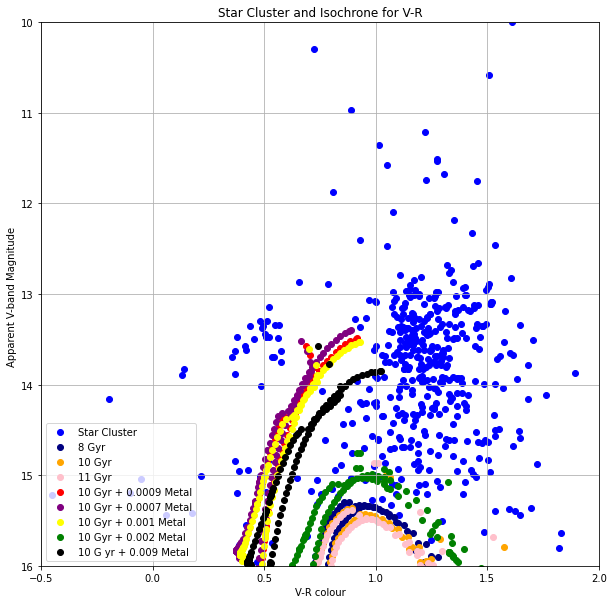

10000.0
For comparison, literature values for the Star Cluster distance are about 86 pc


In [486]:
# Solution

# Define plot size
plt.rcParams['figure.figsize'] = [10, 10]
plt.axis([-0.5, 2, 16, 10])  
# Axis labels and grid
plt.xlabel('V-R colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Star Cluster')
plt.grid(True)
px=[]
py=[]
for idx, mag in enumerate(V_mag):
    py.append(V_mag[idx])
    px.append(V_mag[idx]-R_mag[idx])
plt.scatter(px,py,label='Star Cluster',color='blue')

DM=15

# All of the following lines that are commented out are set up so that we could easily swap between isochrones without having to change to much

VR1=np.array(isochrone[0].V)-np.array(isochrone[0].R)
V1=np.array(isochrone[0].V)+DM+VR1
plt.scatter(VR1, V1, label='8 Gyr',color='navy')

VR2=np.array(isochrone[1].V)-np.array(isochrone[1].R)
V2=np.array(isochrone[1].V)+DM+VR2
plt.scatter(VR2, V2, label='10 Gyr',color='orange')                         

VR3=np.array(isochrone[2].V)-np.array(isochrone[2].R)
V3=np.array(isochrone[2].V)+DM+VR3
plt.scatter(VR3, V3, label='11 Gyr',color='pink') 

VR4=np.array(isochrone[3].V)-np.array(isochrone[3].R)
V4=np.array(isochrone[3].V)+DM+VR4
plt.scatter(VR4, V4, label='10 Gyr + 0.0009 Metal',color='red') 

VR5=np.array(isochrone[4].V)-np.array(isochrone[4].R)
V5=np.array(isochrone[4].V)+DM+VR5
plt.scatter(VR5, V5, label='10 Gyr + 0.0007 Metal',color='purple') 

VR6=np.array(isochrone[5].V)-np.array(isochrone[5].R)
V6=np.array(isochrone[5].V)+DM+VR6
plt.scatter(VR6, V6, label='10 Gyr + 0.001 Metal',color='yellow') 

VR7=np.array(isochrone[6].V)-np.array(isochrone[6].R)
V7=np.array(isochrone[6].V)+DM+VR7
plt.scatter(VR7, V7, label='10 Gyr + 0.002 Metal',color='green') 

VR8=np.array(isochrone[7].V)-np.array(isochrone[7].R)
V8=np.array(isochrone[7].V)+DM+VR8
plt.scatter(VR8, V8, label='10 G yr + 0.009 Metal',color='black') 



# Scatter plot

# Axis labels and grid
plt.xlabel('B-V colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Star Cluster and Isochrone')
plt.grid(True)
plt.legend(loc='lower left')


# Output file, if wanted
#plt.savefig("V_R_All isochrones.png")

# Axis labels and grid
plt.xlabel('V-R colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Star Cluster and Isochrone for V-R')
plt.grid(True)
plt.legend(loc='lower left')

# Plot to screen
plt.show()


distance=10.0*pow(10,0.2*DM)
print(distance)

print('For comparison, literature values for the Star Cluster distance are about 86 pc')

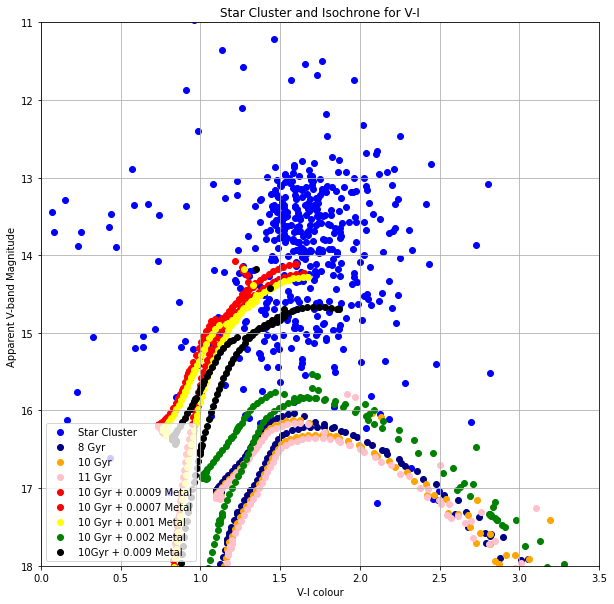

10000.0
For comparison, literature values for the Star Cluster distance are about 9kpc


In [489]:
# Solution

# Define plot size
plt.rcParams['figure.figsize'] = [10, 10]
plt.axis([0,3.5, 18, 11])  
# Axis labels and grid
plt.xlabel('V-R colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Star Cluster')
plt.grid(True)
px=[]
py=[]
for idx, mag in enumerate(V_mag):
    py.append(V_mag[idx])
    px.append(V_mag[idx]-I_mag[idx])
plt.scatter(px,py,label='Star Cluster',color='blue')

DM=15

VI1=np.array(isochrone[0].V)-np.array(isochrone[0].I)
V1=np.array(isochrone[0].V)+DM+VI1
plt.scatter(VI1, V1, label='8 Gyr',color='navy')

VI2=np.array(isochrone[1].V)-np.array(isochrone[1].I)
V2=np.array(isochrone[1].V)+DM+VI2
plt.scatter(VI2, V2, label='10 Gyr',color='orange')                         # Scatter plot


VI3=np.array(isochrone[2].V)-np.array(isochrone[2].I)
V3=np.array(isochrone[2].V)+DM+VI3
plt.scatter(VI3, V3, label='11 Gyr',color='pink') 

VI4=np.array(isochrone[3].V)-np.array(isochrone[3].I)
V4=np.array(isochrone[3].V)+DM+VI4
plt.scatter(VI4, V4, label='10 Gyr + 0.0009 Metal',color='red') 

VI5=np.array(isochrone[4].V)-np.array(isochrone[4].I)
V5=np.array(isochrone[4].V)+DM+VI5
plt.scatter(VI5, V5, label='10 Gyr + 0.0007 Metal',color='red') 

VI6=np.array(isochrone[5].V)-np.array(isochrone[5].I)
V6=np.array(isochrone[5].V)+DM+VI6
plt.scatter(VI6, V6, label='10 Gyr + 0.001 Metal',color='yellow') 

VI7=np.array(isochrone[6].V)-np.array(isochrone[6].I)
V7=np.array(isochrone[6].V)+DM+VI7
plt.scatter(VI7, V7, label='10 Gyr + 0.002 Metal',color='green') 

VI8=np.array(isochrone[7].V)-np.array(isochrone[7].I)
V8=np.array(isochrone[7].V)+DM+VI8
plt.scatter(VI8, V8, label='10Gyr + 0.009 Metal',color='black') 



# Axis labels and grid
plt.xlabel('V-I colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Star Cluster and Isochrone')
plt.grid(True)
plt.legend(loc='lower left')


# Output file, if wanted
plt.savefig("V-I_All isochrones.png")

# Axis labels and grid
plt.xlabel('V-I colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Star Cluster and Isochrone for V-I')
plt.grid(True)
plt.legend(loc='lower left')

# Plot to screen
plt.show()


distance=10.0*pow(10,0.2*DM)
print(distance)

print('For comparison, literature values for the Star Cluster distance are about 9kpc')

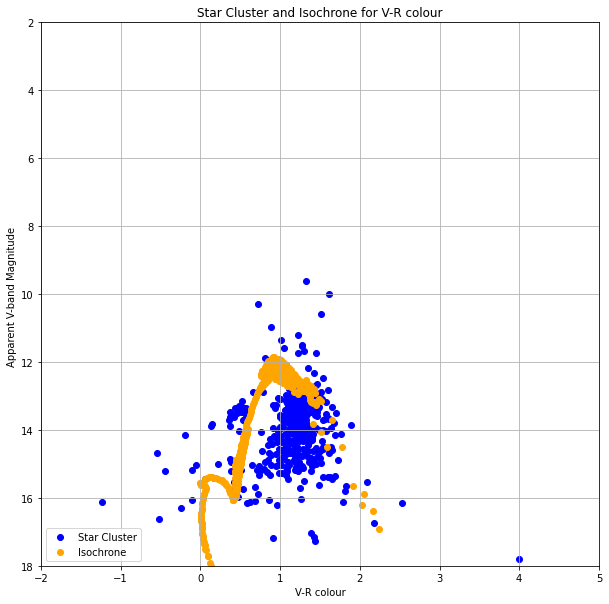

10000.0
Literature values for the Star Cluster distance are about 9.6 kpc


In [404]:
# Solution

# Define plot size

plt.axis([-2, 5, 18, 2.0])  
# Axis labels and grid
plt.xlabel('V-R colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Star Cluster')
plt.grid(True)
px=[]
py=[]
for idx, mag in enumerate(V_mag):
    py.append(V_mag[idx])
    px.append(V_mag[idx]-R_mag[idx])
plt.scatter(px,py,label='Star Cluster',color='blue')

plt.rcParams['figure.figsize'] = [10, 10]
EBV=0.00
EVR=1.0*EBV       # dust reddening making the V-R colour 0.1 magnitudes redder XXXXX NEEDS FIXING!!!!!XXXX
RV=3.1*EBV     # dust will make the magnitudes appear fainter by 3.1 * E(B-V) - fairly standard
DM =15    # Distance modulus

VR=np.array(isochrone[2].V)-np.array(isochrone[2].R)
V=np.array(isochrone[2].V) +DM
plt.scatter(VR, V, label='Isochrone',color='orange')                         # Scatter plot

# Axis labels and grid
plt.xlabel('V-R colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Star Cluster and Isochrone for V-R colour')
plt.grid(True)
plt.legend(loc='lower left')


# Output file, if wanted
plt.savefig("V-I_All isochrones.png")

# Axis labels and grid
plt.xlabel('V-R colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Star Cluster and Isochrone for V-R colour')
plt.grid(True)
plt.legend(loc='lower left')

# Plot to screen
plt.show()


distance=10.0*pow(10,DM*0.2)+RV
print(distance)

print('Literature values for the Star Cluster distance are about 9.6 kpc')

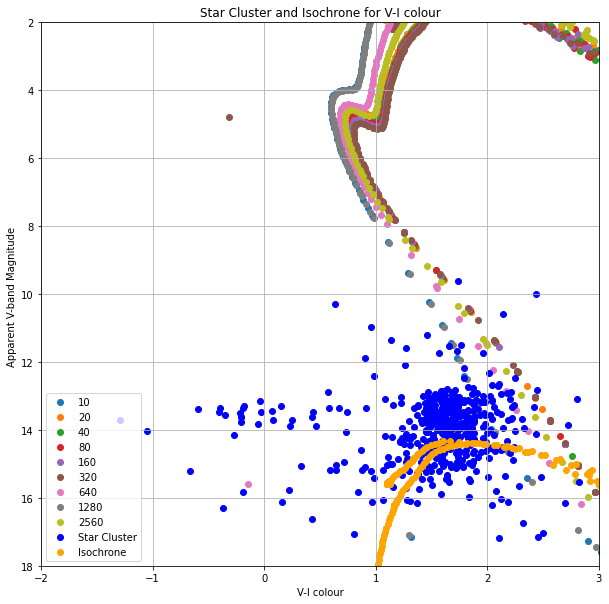

16.003931924611138
For comparison, literature values for the Star Cluster distance are about 86 pc


In [393]:


# Define plot size
plt.rcParams['figure.figsize'] = [10, 10]
DM=14
EVI=0.05       # dust reddening making the V-R colour 0.1 magnitudes redder
RV=3.1*EVI     # dust will make the magnitudes appear fainter by 3.1 * E(B-V) - fairly standard

for tiso in isochrone:
    VI=np.array(tiso.V)-np.array(tiso.I)+EVI
    V=np.array(tiso.V)+VI
    plt.scatter(VI, V, label=str(tiso.age))                         # Scatter plot

plt.axis([-2, 3, 18, 2.0])  
# Axis labels and grid
plt.xlabel('V-I colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Star Cluster')
plt.legend(loc='lower left')
plt.grid(True)
px=[]
py=[]
for idx, mag in enumerate(V_mag):
    py.append(V_mag[idx])
    px.append(V_mag[idx]-I_mag[idx])
plt.scatter(px,py,label='Star Cluster',color='blue')


VI=np.array(isochrone[2].V)-np.array(isochrone[2].I)
V=np.array(isochrone[2].V)+DM+VR
plt.scatter(VI, V, label='Isochrone',color='orange')                         # Scatter plot

# Output file, if wanted
# plt.savefig("test.png")

# Axis labels and grid
plt.xlabel('V-I colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Star Cluster and Isochrone for V-I colour')
plt.grid(True)
plt.legend(loc='lower left')

# Plot to screen
plt.show()


distance=10.0*pow(10,0.2)+RV
print(distance)

print('For comparison, literature values for the Star Cluster distance are about 86 pc')

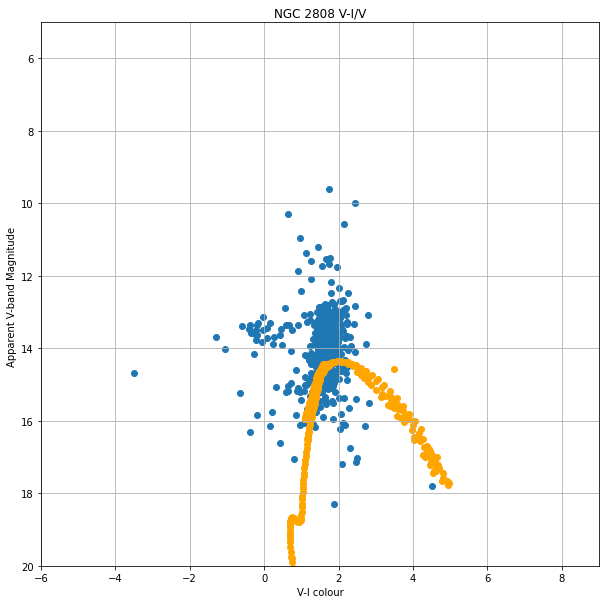

In [394]:
# need a V-I against V
# Define plot size
plt.rcParams['figure.figsize'] = [10, 10]
plt.axis([-6, 9, 20, 5])  
    
# Axis labels and grid
plt.xlabel('V-I colour')          
plt.ylabel('Apparent V-band Magnitude ')
plt.title('NGC 2808 V-I/V')
plt.grid(True)
px=[]
py=[]
for idx, mag in enumerate(V_mag):
    py.append(V_mag[idx])
    px.append(V_mag[idx]-I_mag[idx])
plt.scatter(px,py)
DM=15
VI=np.array(isochrone[1].V)-np.array(isochrone[1].I)
V=np.array(isochrone[1].V)+DM
plt.scatter(VI, V, label='Isochrone',color='orange')                         # Scatter plot

plt.show()

                         # Scatter plot



(array([  3.,   3.,  10.,  43., 213., 116.,  72.,  19.,   7.,   4.]),
 array([ 9.60661194, 10.47669306, 11.34677419, 12.21685531, 13.08693644,
        13.95701756, 14.82709869, 15.69717981, 16.56726094, 17.43734206,
        18.30742319]),
 <BarContainer object of 10 artists>)

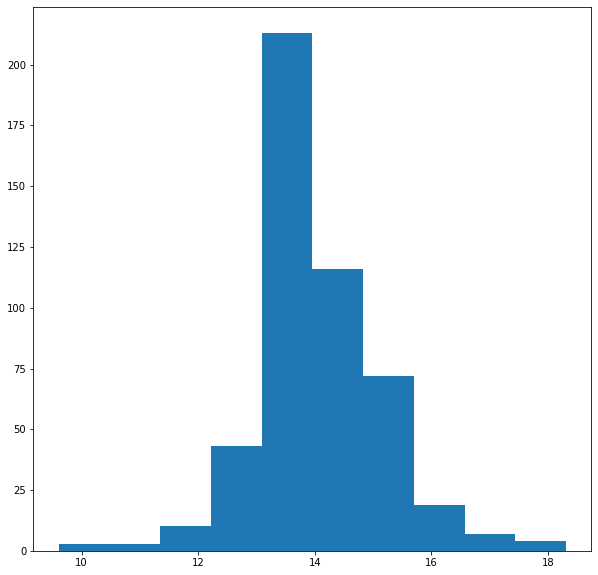

In [395]:
plt.hist(V_mag)

In [396]:
for idx in range(len(V_mag)):
    print(V_mag[idx]-I_mag[idx])

1.2682737162705173
-0.6625873980703041
1.2704746055946998
0.5891776875809835
2.4977549262263636
1.7673431982702255
1.564786124221703
2.157332994477688
1.7951313261761044
1.7865916980923764
1.1572816730702868
2.040258660466735
1.272777552531874
1.8053118557560026
nan
2.7259116800694034
1.6853410724272742
0.6407317834624724
1.3699523182209177
1.8802413646650251
nan
1.5193026536168635
2.8168745544475726
1.5985064906430129
1.83983558279564
0.7331002867363487
1.7154249219638036
2.3097687491274623
2.4580284113045305
2.8031510648154434
4.500462962937775
1.8308733517508493
2.0236817081480734
1.6168508983359775
2.1405755501232004
2.4779705626211346
1.8349943024100632
2.009697227721091
1.9496493096403
2.039860647844961
1.7745185516082103
0.8041497506456423
2.221093506592471
1.5493265578303177
1.6795478309312166
1.2637952674590611
1.4019862808502648
1.2396464567889023
nan
1.743034164882042
0.5704875408167673
1.1085465256561466
2.4345078132512565
2.202830337097451
1.8356474187289926
1.271377668894

In [397]:
print(V_mag)

[11.575777481718085, 15.223842025709857, 14.133060225917792, 15.191836327609044, 17.03859233764865, 14.885185640396084, 13.076134740137954, 15.367090132390778, 12.469944708096115, 12.17950864998501, 13.259761440391573, 16.219916746290572, 14.93694877675702, 14.73552331025991, nan, 13.869048029975446, 14.422315096345791, 15.184052615981491, 14.38753002921245, 14.095196196103547, nan, 15.031873956662132, 15.520794362844814, 15.072059771022204, 15.96097000370493, 14.071584833961719, 15.13121190281211, 13.676089968344385, 17.145805500975875, 13.089583008345423, 17.805522666894138, 14.045088637851855, 13.993350521567725, 14.603753099300045, 14.490086711405747, 15.395893431631231, 13.718243303935303, 15.372780724323672, 14.366011927342662, 13.672963425896567, 14.872983642627126, 17.055076669068413, 13.649214105689243, 14.45512900195995, 13.681438304306763, 12.09875807071633, 14.507794983095714, 15.322083480783322, 17.269562363249726, 14.981992821543933, 12.887633929697355, 14.792051838990737